# Plotting Example: Covid-19 and Schools

**Author**

> - [Paul Schrimpf *UBC*](https://economics.ubc.ca/faculty-and-staff/paul-schrimpf/)  


**Prerequisites**

- [Visualization Rules](https://datascience.quantecon.org/visualization_rules.html)



**Outcomes**

- Be able to build visualizations with multiple subplots  
- Add plot elements using data from multiple DataFrames  
- Understand the relationship between the matplotlib Figure and Axes
  objects  
- Customize fonts, legends, axis labels, tick labels, titles, and more!  
- Save figures to files to add to presentation, email, or use outside
  of a Jupyter notebook  


**Data**

- Covid cases and deaths
- School district closure, opening, and policies


In [182]:
# Uncomment following line to install on colab
#! pip install 

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


%matplotlib inline

# Introduction

In a recent article, ["The association of opening K–12 schools with the spread of COVID-19 in the United States: County-level panel data analysis", Chernozhukov, Kasahara, and Schrimpf (2021)](https://doi.org/10.1073/pnas.2103420118) present evidence that opening schools for in-person learning may have increased the spread of Covid-19, especially where schools did not require masks. 

The paper uses data on US counties from April 2020 to December 2020. This notebook will examine whether the paper's findings hold in more recent data.

More specifically, we will recreate panels A and B of Figure 1 from the paper.

![Figure 1](https://www.pnas.org/content/pnas/118/42/e2103420118/F1.large.jpg)

# Data 

We will use data from three sources.

1. County level cases and deaths from the [NYTimes git repository](https://github.com/nytimes/covid-19-data/tree/master/rolling-averages).
2. School district openings, closures, and Covid policies from [MCH Strategic data](https://www.mchdata.com/covid19/schoolclosings)
3. Matching between school districts and counties from the [US Census Bureau](https://www2.census.gov/programs-surveys/saipe/guidance-geographies/districts-counties/)

## Cases and Deaths

In [13]:
try : # don't redownload if cases already exists
  cases
except :
  cases = pd.concat(
    [pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/rolling-averages/us-counties-2020.csv'),
     pd.read_csv('https://github.com/nytimes/covid-19-data/raw/master/rolling-averages/us-counties-2021.csv')], 
    axis=0
    )

cases.head()

,date,geoid,county,state,cases,cases_avg,cases_avg_per_100k,deaths,deaths_avg,deaths_avg_per_100k
0,2020-01-21,USA-53061,Snohomish,Washington,1,0.14,0.02,0,0.0,0.0
1,2020-01-22,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
2,2020-01-23,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
3,2020-01-24,USA-53061,Snohomish,Washington,0,0.14,0.02,0,0.0,0.0
4,2020-01-24,USA-17031,Cook,Illinois,1,0.14,0.00,0,0.0,0.0


For mergeing this data with the other data sources, we will County FIPS codes. The `geoid` column contains the county FIPS codes preceded by "USA-". Let's extract the FIPS codes.

In [16]:
cases['fips'] = pd.to_numeric(cases['geoid'].str[4:])

## School Policies

In [21]:
# 2020 data 
try :
  mch2020
except: 
  mch2020 = pd.read_csv('https://github.com/ubcecon/covid-schools/raw/master/data/covid-school-data.csv')

mch2020.head()

,SchoolYear,DistrictNCES,DistrictID,DistrictName,Control,PhysicalCity,PhysicalState,Enrollment,OpenDate,TeachingMethod,...,OnlineInstructionIncrease,NetworkInvestment,HardwareInvestment,StaffMaskPolicy,StudentMaskPolicy,StudentIllnessReturnPolicy,StudentIsolationArea,SchoolTemporaryShutdown,ParentOptOutClassroomTeaching,LastVerifiedDate
0,2020-2021,200004.0,888659,Yupiit School District,Public,Akiachak,AK,463.0,08/12/2020,Online Only,...,No,No,No,Required for all staff,Required for all students,Yes,No,Closed indefinitely,Yes,01/11/2021
1,2020-2021,NaN,2442904,Alaska Conference of SDA Education Dept,Private,Anchorage,AK,NaN,09/08/2020,Hybrid,...,No,Unknown,Unknown,Required for all staff,Required for all students,Yes,Unknown,Never closed,Unknown,11/09/2020
2,2020-2021,200010.0,888610,Aleutian Region School District,Public,Anchorage,AK,27.0,09/08/2020,On Premises,...,Unknown,Yes,Yes,Required for all staff,Required for all students,Unknown,Unknown,Never closed,Yes,11/30/2020
3,2020-2021,200180.0,888658,Anchorage School District,Public,Anchorage,AK,48347.0,08/25/2020,Online Only,...,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Unknown,12/28/2020
4,2020-2021,200800.0,888657,Chugach School District,Public,Anchorage,AK,517.0,08/17/2020,Online Only,...,Yes,Unknown,Unknown,Required for all staff,Required for all students,Yes,Yes,Closed 6-14 days,Yes,01/04/2021


In [26]:
mch2020.columns

Index(['SchoolYear', 'DistrictNCES', 'DistrictID', 'DistrictName', 'Control',
       'PhysicalCity', 'PhysicalState', 'Enrollment', 'OpenDate',
       'TeachingMethod', 'SportsParticipation', 'OnlineInstructionIncrease',
       'NetworkInvestment', 'HardwareInvestment', 'StaffMaskPolicy',
       'StudentMaskPolicy', 'StudentIllnessReturnPolicy',
       'StudentIsolationArea', 'SchoolTemporaryShutdown',
       'ParentOptOutClassroomTeaching', 'LastVerifiedDate'],
      dtype='object')

In [22]:
# 2021
try :
  mch2021
except : # reading from excel takes a bit of time, so only do it once
  mch2021 = pd.read_excel('covid-school-data-fall2021.xlsx')
mch2021.head()

,SchoolYear,DistrictNCES,DistrictID,DistrictName,Control,PhysicalCity,PhysicalState,Enrollment,TeachingMethod,ElementaryTeachingOnPremise,...,SchoolVaccinationClinic,ExtracurricularParticipation,ExtracurricularPreventionMask,ExtracurricularPreventionTesting,ExtracurricularPreventionDistance,ExtracurricularPreventionVaccination,ExtracurricularPreventionVentilation,ExtracurricularPreventionHandwashing,ExtracurricularPreventionNone,LastVerifiedDate
0,2021-2022,200004.0,888659,Yupiit School District,Public,Akiachak,AK,453.0,Full In-Person,Yes,...,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,10/12/2021
1,2021-2022,200010.0,888610,Aleutian Region School District,Public,Anchorage,AK,27.0,Full In-Person,Yes,...,No,No,Pending,Pending,Pending,Pending,Pending,Pending,Pending,10/14/2021
2,2021-2022,200180.0,888658,Anchorage School District,Public,Anchorage,AK,48211.0,Other,Yes,...,Yes,Yes,Yes,Pending,Yes,Pending,Pending,Pending,Pending,10/14/2021
3,2021-2022,200800.0,888657,Chugach School District,Public,Anchorage,AK,514.0,Hybrid/Partial,Pending,...,No,Yes,Pending,Pending,Pending,Yes,Pending,Pending,Pending,10/14/2021
4,2021-2022,200730.0,888599,Chatham School District,Public,Angoon,AK,143.0,Pending,Pending,...,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,Pending,NaN


In [28]:
mch2021.columns

Index(['SchoolYear', 'DistrictNCES', 'DistrictID', 'DistrictName', 'Control',
       'PhysicalCity', 'PhysicalState', 'Enrollment', 'TeachingMethod',
       'ElementaryTeachingOnPremise', 'ElementaryTeachingHybrid',
       'ElementaryTeachingRemoteOnline', 'ElementaryTeachingUnknown',
       'ElementaryTeachingOther', 'MiddleTeachingOnPremise',
       'MiddleTeachingHybrid', 'MiddleTeachingRemoteOnline',
       'MiddleTeachingUnknown', 'MiddleTeachingOther', 'HighTeachingOnPremise',
       'HighTeachingHybrid', 'HighTeachingRemoteOnline', 'HighTeachingUnknown',
       'HighTeachingOther', 'ParentOptOutClassroomTeaching',
       'StudentAllRemotePercent', 'TeachingMethodJan2021',
       'TeachingMethodLastMonth2021', 'StaffCovidTesting',
       'StudentCovidTesting', 'SportsParticipation', 'StaffMaskPolicy',
       'ElementaryStudentMaskPolicy', 'MiddleStudentMaskPolicy',
       'HighStudentMaskPolicy', 'SchoolYearStartDate',
       'SchoolYearStaggeredStart', 'SocialDistancingPolicy',


In [33]:
mch2021.StaffMaskPolicy.value_counts()

Yes                                             6550
Pending                                         4969
Not required                                    4426
Unknown                                          640
Required for unvaccinated teachers and staff     175
Name: StaffMaskPolicy, dtype: int64

Let's make a figure to summarize how school policies changed from 2020 to 2021. 

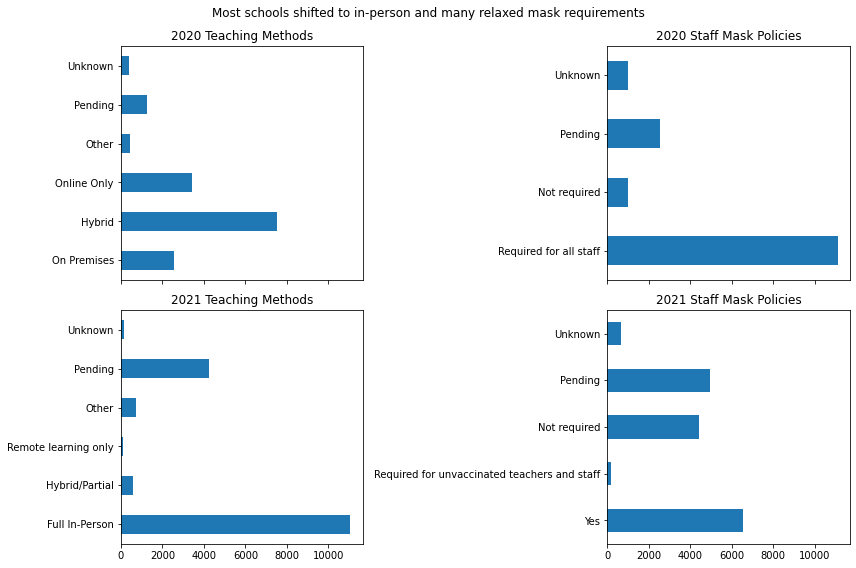

In [46]:
fig, ax = plt.subplots(2,2, figsize=(12,8), sharex=True)

mch2020.TeachingMethod.value_counts()[['On Premises','Hybrid','Online Only','Other','Pending','Unknown']].plot(kind='barh', ax=ax[0,0])
ax[0,0].set_title('2020 Teaching Methods')

mch2020.StaffMaskPolicy.value_counts()[['Required for all staff','Not required','Pending','Unknown']].plot(kind='barh', ax=ax[0,1])
ax[0,1].set_title('2020 Staff Mask Policies')

mch2021.TeachingMethod.value_counts()[['Full In-Person','Hybrid/Partial','Remote learning only','Other','Pending','Unknown']].plot(kind='barh', ax=ax[1,0])
ax[1,0].set_title('2021 Teaching Methods')
mch2021.StaffMaskPolicy.value_counts()[['Yes','Required for unvaccinated teachers and staff','Not required','Pending','Unknown']].plot(kind='barh', ax=ax[1,1])
ax[1,1].set_title('2021 Staff Mask Policies')

fig.suptitle('Most schools shifted to in-person and many relaxed mask requirements')
fig.tight_layout()

This figure remains a work-in-progress. It has some good things and some bad. On the plus side, the title and contents have a clear message. However, the formatting could be improved. The labels are different for the two years. Colors could be used to highlight the different type of information in the two columns. This layout might not be best. Maybe it would be better as two figures with two subplots each instead of one figure with four subplots.

## School district to County FIPS Mapping



In [94]:
# you might have to install xlrd
# !pip install xlrd 
try :
  sdlist
except :  
  sdlist = pd.read_excel('https://www2.census.gov/programs-surveys/saipe/guidance-geographies/districts-counties/sdlist-20.xls', 
                        skiprows=2)
# combing state and county fips to a single 5 digit fips code
sdlist['fips'] = sdlist['State FIPS']*1000 + sdlist['County FIPS']
# combine state fips and district id to get district NCES
sdlist['NCES'] = sdlist['State FIPS']*100_000 + sdlist['District ID Number']

sdlist.head()

,State Postal Code,State FIPS,District ID Number,School District Name,County Names,County FIPS,fips,NCES
0,AL,1,190,Alabaster City School District,Shelby County,117,1117,100190
1,AL,1,5,Albertville City School District,Marshall County,95,1095,100005
2,AL,1,30,Alexander City City School District,Tallapoosa County,123,1123,100030
3,AL,1,60,Andalusia City School District,Covington County,39,1039,100060
4,AL,1,90,Anniston City School District,Calhoun County,15,1015,100090


# Merge Data

Many counties contain multiple school districts, and some school districts contain multiple counties. This makes combining the school district data with the county level case data slightly complicated.

We will first combine the MCH school district data with the county FIPS codes from the census. Then for each county, we will compute county level school variables as the enrollment weighted average (or some other appropriate aggregate) of the variable for the school districts in that county.

## School Districts to Counties


In [149]:
def weighted_portions(df, x, w) :
  """
  Return the weighted by `w` portion in each category of `x`
  """
  res = df.groupby(x)[w].sum() / df[w].sum()
  return(res)

### 2020

In [141]:
s20 = pd.merge(mch2020, sdlist, left_on="DistrictNCES", right_on="NCES", how='right')

In [217]:
teaching = s20.groupby('fips').apply(weighted_portions,'TeachingMethod','Enrollment').unstack()
teaching.rename({'On Premises':'In-Person','Online Only':'Online'},axis=1, inplace=True)
teaching.replace(np.nan, 0.0, inplace=True)
teaching['Teaching Unknown'] = teaching['Other'] + teaching['Pending'] + teaching['Unknown']
teaching.drop(['Unknown','Other','Pending'], axis=1, inplace=True)
teaching['Year']=2020

In [213]:
mask = s20.groupby('fips').apply(weighted_portions,'StaffMaskPolicy','Enrollment').unstack()
mask.replace(np.nan, 0.0, inplace=True)
mask.rename({'Required for all staff':'Masks required for staff','Not required':'Masks not required for staff'},axis=1,inplace=True)
mask['Masks unknown for staff'] = mask['Pending'] + mask['Unknown']
mask.drop(['Pending','Unknown'],axis=1,inplace=True)
mask['Year']=2020

In [259]:
def weighted_average_date(dates, weight, basedate=pd.to_datetime('2020-01-01')):
  """
  Return the weighted average of the values in `dates`
  """
  days = (dates - basedate).dt.days
  if all(np.isnan(days)):
    return(pd.NaT)
  weight[np.isnan(days)] = 0
  days.fillna(0, inplace=True)
  weight.fillna(0, inplace=True)
  avgday = np.average(days, weights=weight)
  return(basedate + pd.Timedelta(days=avgday))
  
s20['OpenDate'] = pd.to_datetime(s20['OpenDate'])
opening = s20.groupby('fips').apply(lambda x: weighted_average_date(x.OpenDate, weight=x.Enrollment))
opening.name = 'OpeningDate'

In [263]:
countyschool = pd.merge(teaching,mask, on=['fips','Year']).join(opening)

In [264]:
countyschool

,Hybrid,In-Person,Online,Teaching Unknown,Year,Masks not required for staff,Masks required for staff,Masks unknown for staff,OpeningDate
fips,,,,,,,,,
1001,1.000000,0.000000,0.000000,0.0,2020,0.000000,1.000000,0.0,2020-09-08 00:00:00.000000
1003,0.000000,0.000000,0.000000,1.0,2020,0.000000,0.000000,1.0,2020-09-14 00:00:00.000000
1005,0.877453,0.000000,0.122547,0.0,2020,0.000000,1.000000,0.0,2020-08-22 07:52:53.964497
1007,1.000000,0.000000,0.000000,0.0,2020,0.000000,0.000000,1.0,2020-08-18 00:00:00.000000
1009,1.000000,0.000000,0.000000,0.0,2020,0.000000,1.000000,0.0,2020-08-18 00:00:00.000000
...,...,...,...,...,...,...,...,...,...
56037,0.822033,0.177967,0.000000,0.0,2020,0.000000,1.000000,0.0,2020-08-17 11:42:23.838464
56039,1.000000,0.000000,0.000000,0.0,2020,0.000000,1.000000,0.0,2020-09-01 00:00:00.000000
56041,0.378247,0.621753,0.000000,0.0,2020,0.178571,0.821429,0.0,2020-08-24 09:35:03.896104
